# 2023 TD Regression with Play-by-Play Data: Running Backs

In this notebook, I am going to try to find TD regression candidates by using play-by-play data to calculate the expected amount of TDs a player should have scored and compare this to the actual amount scored. This will be for running backs.

In [1]:
#Import libraries, nflfastpy will be used to get play-by-play data
import pandas as pd
import numpy as np
import nfl_data_py as nfl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Play by play data since 2010
seasons = range(2010, 2023)
df = nfl.import_pbp_data(seasons)

2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [3]:
#Find relevant RB columns
for column in df.columns:
    #look for rushing relevant columns
    if 'rush' in column:
        print(column)
    #look for yardline and distance to endzone columns
    elif 'distance' in column:
        print(column)
    elif 'yardline' in column:
        print(column)

yardline_100
kick_distance
total_home_rush_epa
total_away_rush_epa
total_home_rush_wpa
total_away_rush_wpa
first_down_rush
rush_attempt
rush_touchdown
lateral_rush
rusher_player_id
rusher_player_name
rushing_yards
lateral_rusher_player_id
lateral_rusher_player_name
lateral_rushing_yards
rusher
rusher_jersey_number
rush
rusher_id
number_of_pass_rushers


In [4]:
#Df with relevant columns
rushing_df = df[['rush_attempt', 'rush_touchdown', 'yardline_100', 'two_point_attempt']]
rushing_df = rushing_df.loc[(rushing_df['two_point_attempt'] == 0) & (rushing_df['rush_attempt'] == 1)]

rushing_df.head()

,rush_attempt,rush_touchdown,yardline_100,two_point_attempt
3,1.0,0.0,78.0,0.0
6,1.0,0.0,38.0,0.0
8,1.0,0.0,24.0,0.0
9,1.0,0.0,22.0,0.0
11,1.0,0.0,19.0,0.0


In [5]:
#Calculate probability of scoring TD from each yardline
rushing_df_probs = rushing_df.groupby('yardline_100')['rush_touchdown'].value_counts(normalize = -True)
rushing_df_probs = pd.DataFrame({
    'probability_of_touchdown': rushing_df_probs.values
}, index=rushing_df_probs.index).reset_index()

rushing_df_probs.head()

,yardline_100,rush_touchdown,probability_of_touchdown
0,1.0,1.0,0.559069
1,1.0,0.0,0.440931
2,2.0,0.0,0.590909
3,2.0,1.0,0.409091
4,3.0,0.0,0.664357


In [6]:
#Only keeping rush_touchdown = 1
rushing_df_probs = rushing_df_probs.loc[rushing_df_probs['rush_touchdown'] == 1]

#Drop rush_touchdown, since that's also redundant.
rushing_df_probs = rushing_df_probs.drop('rush_touchdown', axis=1)
rushing_df_probs.head(15)

,yardline_100,probability_of_touchdown
0,1.0,0.559069
3,2.0,0.409091
5,3.0,0.335643
7,4.0,0.281701
9,5.0,0.216901
11,6.0,0.153671
13,7.0,0.151988
15,8.0,0.129257
17,9.0,0.081663
19,10.0,0.097050


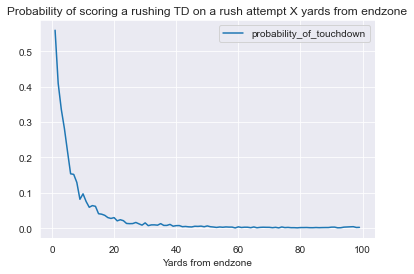

In [7]:
#Plot probabilty of scoring rush TD x-distance from endzone
rushing_df_probs.plot(x='yardline_100', y='probability_of_touchdown');
plt.title('Probability of scoring a rushing TD on a rush attempt X yards from endzone');
plt.xlabel('Yards from endzone');

In [8]:
#2022 season play-by-play data
pbp_2022 = nfl.import_pbp_data([2022])

2022 done.
Downcasting floats.


In [9]:
#Relevant columns for RBs
pbp_2022 = pbp_2022[['rusher_player_name', 'rusher_player_id', 'posteam', 'rush_touchdown', 'yardline_100']].dropna()
pbp_2022.head()

,rusher_player_name,rusher_player_id,posteam,rush_touchdown,yardline_100
2,Mi.Carter,00-0036924,NYJ,0.0,78.0
4,Mi.Carter,00-0036924,NYJ,0.0,59.0
9,L.Jackson,00-0034796,BAL,0.0,64.0
10,K.Drake,00-0033118,BAL,0.0,60.0
12,K.Drake,00-0033118,BAL,0.0,52.0


In [10]:
#Merge 2022 play-by-play df with rushing TD probability df
exp_df = pbp_2022.merge(rushing_df_probs, how='left', on='yardline_100')

exp_df.head()

,rusher_player_name,rusher_player_id,posteam,rush_touchdown,yardline_100,probability_of_touchdown
0,Mi.Carter,00-0036924,NYJ,0.0,78.0,0.001490
1,Mi.Carter,00-0036924,NYJ,0.0,59.0,0.000814
2,L.Jackson,00-0034796,BAL,0.0,64.0,0.001495
3,K.Drake,00-0033118,BAL,0.0,60.0,0.003862
4,K.Drake,00-0033118,BAL,0.0,52.0,0.003322


In [11]:
#Clean/prep data
#Aggregate prob of TD and rush TD columns, and rename
exp_df = exp_df.groupby(['rusher_player_name', 'rusher_player_id', 'posteam'], as_index = False).agg({
    'probability_of_touchdown': np.sum,
    'rush_touchdown': np.sum
}).rename({'probability_of_touchdown': 'Expected Touchdowns'}, axis = 1)

#Sort by expected TDs
exp_df = exp_df.sort_values(by='Expected Touchdowns', ascending = False)

#Rename columns
exp_df = exp_df.rename(columns={
    "rusher_player_name": "Player", 
    "posteam": "Team",
    "rusher_player_id":"ID",
    'rush_touchdown': 'Actual Touchdowns'
})

#Rank for expected TDs
exp_df['Expected Touchdowns Rank'] = exp_df['Expected Touchdowns'].rank(ascending = False)

exp_df.head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank
214,Ja.Williams,00-0033948,DET,17.521111,17.0,1.0
180,J.Hurts,00-0036389,PHI,15.345688,18.0,2.0
132,E.Elliott,00-0033045,DAL,11.381789,12.0,3.0
193,J.Mixon,00-0033897,CIN,11.260078,8.0,4.0
85,D.Cook,00-0033893,MIN,9.676769,8.0,5.0
182,J.Jacobs,00-0035700,LV,9.396471,12.0,6.0
346,T.Etienne,00-0036973,JAX,9.396275,6.0,7.0
270,M.Sanders,00-0035243,PHI,9.306798,13.0,8.0
320,S.Barkley,00-0034844,NYG,8.899824,12.0,9.0
95,D.Henry,00-0032764,TEN,8.898533,13.0,10.0


In [12]:
#Remove non-RBs
roster = nfl.import_rosters([2022])
roster = roster[['player_id', 'position']].rename(columns = {"player_id": "ID"}) 

exp_df = exp_df.merge(roster, on='ID')
exp_df = exp_df[exp_df['position'] == 'RB'].drop('position', axis=1)

In [13]:
#Rank for actual TDs
exp_df['Actual Touchdowns Rank'] = exp_df['Actual Touchdowns'].rank(ascending=False)

exp_df.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank
0,Ja.Williams,00-0033948,DET,17.521111,17.0,1.0,1.0
2,E.Elliott,00-0033045,DAL,11.381789,12.0,3.0,6.5
3,J.Mixon,00-0033897,CIN,11.260078,8.0,4.0,12.5
4,D.Cook,00-0033893,MIN,9.676769,8.0,5.0,12.5
5,J.Jacobs,00-0035700,LV,9.396471,12.0,6.0,6.5


In [14]:
#Regression ranking columns
exp_df['Regression Candidate'] = exp_df['Expected Touchdowns'] - exp_df['Actual Touchdowns']
exp_df['Regression Rank Candidate'] = exp_df['Actual Touchdowns Rank'] - exp_df['Expected Touchdowns Rank']

exp_df.sort_values(by='Regression Candidate').head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
10,A.Ekeler,00-0033699,LAC,8.518543,15.0,11.0,2.0,-6.481457,-9.0
9,D.Henry,00-0032764,TEN,8.898533,13.0,10.0,3.5,-4.101467,-6.5
32,T.Pollard,00-0035261,DAL,5.286359,9.0,32.0,10.0,-3.713641,-22.0
13,N.Chubb,00-0034791,CLE,8.291659,12.0,13.0,6.5,-3.708341,-6.5
7,M.Sanders,00-0035243,PHI,9.306798,13.0,8.0,3.5,-3.693202,-4.5
33,C.Patterson,00-0030578,ATL,4.811344,8.0,33.0,12.5,-3.188656,-20.5
8,S.Barkley,00-0034844,NYG,8.899824,12.0,9.0,6.5,-3.100176,-2.5
5,J.Jacobs,00-0035700,LV,9.396471,12.0,6.0,6.5,-2.603529,0.5
16,K.Walker,00-0038134,SEA,7.525047,10.0,16.0,9.0,-2.474953,-7.0
35,J.Conner,00-0033553,ARI,4.626451,7.0,35.0,16.5,-2.373549,-18.5


In [15]:
#Sort by regression candidate at top
exp_df.sort_values(by='Regression Candidate', ascending=False).head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
19,T.Allgeier,00-0037263,ATL,6.694633,3.0,19.0,42.0,3.694633,23.0
21,L.Fournette,00-0033856,TB,6.454190,3.0,21.0,42.0,3.454190,21.0
30,B.Robinson,00-0037746,WAS,5.447633,2.0,30.0,56.5,3.447633,26.5
6,T.Etienne,00-0036973,JAX,9.396275,6.0,7.0,19.0,3.396275,12.0
3,J.Mixon,00-0033897,CIN,11.260078,8.0,4.0,12.5,3.260078,8.5
23,A.Gibson,00-0036328,WAS,6.203818,3.0,23.0,42.0,3.203818,19.0
44,J.McKinnon,00-0031376,KC,3.796652,1.0,43.0,80.5,2.796652,37.5
38,M.Gordon,00-0032144,DEN,4.108373,2.0,38.0,56.5,2.108373,18.5
24,D.Pierce,00-0037258,HOU,5.982698,4.0,24.0,32.5,1.982698,8.5
62,R.White,00-0037256,TB,2.854858,1.0,61.0,80.5,1.854858,19.5


In [16]:
#Sort by regression rank
exp_df.sort_values(by='Regression Rank Candidate', ascending=False).head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
44,J.McKinnon,00-0031376,KC,3.796652,1.0,43.0,80.5,2.796652,37.5
95,T.Davis-Price,00-0037827,SF,1.390326,0.0,92.0,126.5,1.390326,34.5
30,B.Robinson,00-0037746,WAS,5.447633,2.0,30.0,56.5,3.447633,26.5
19,T.Allgeier,00-0037263,ATL,6.694633,3.0,19.0,42.0,3.694633,23.0
108,R.Burkhead,00-0030288,HOU,1.186220,0.0,105.0,126.5,1.186220,21.5
21,L.Fournette,00-0033856,TB,6.454190,3.0,21.0,42.0,3.454190,21.0
62,R.White,00-0037256,TB,2.854858,1.0,61.0,80.5,1.854858,19.5
23,A.Gibson,00-0036328,WAS,6.203818,3.0,23.0,42.0,3.203818,19.0
38,M.Gordon,00-0032144,DEN,4.108373,2.0,38.0,56.5,2.108373,18.5
111,J.Williams,00-0036997,DEN,1.128179,0.0,108.0,126.5,1.128179,18.5


In [17]:
#Sort by lowest regression rank
exp_df.sort_values(by='Regression Rank Candidate', ascending=True).head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
365,K.Smith,00-0030968,ATL,0.002076,0.0,373.5,126.5,0.002076,-247.0
364,T.Badie,00-0037085,DEN,0.002285,0.0,372.0,126.5,0.002285,-245.5
279,T.Jones,00-0035860,NO,0.004501,0.0,349.0,126.5,0.004501,-222.5
338,R.Bonnafon,00-0034578,WAS,0.005136,0.0,343.0,126.5,0.005136,-216.5
321,J.Ward,00-0035924,TEN,0.009328,0.0,326.0,126.5,0.009328,-199.5
320,J.Cabinda,00-0034171,DET,0.009368,0.0,325.0,126.5,0.009368,-198.5
78,E.Benjamin,00-0036383,HOU,0.011523,0.0,319.0,126.5,0.011523,-192.5
305,T.Sermon,00-0036984,PHI,0.016227,0.0,307.0,126.5,0.016227,-180.5
301,T.Chandler,00-0037276,MIN,0.017348,0.0,303.0,126.5,0.017348,-176.5
293,D.Felton,00-0036654,CLE,0.021249,0.0,295.0,126.5,0.021249,-168.5


In [18]:
#Delete players with less than 2 exp TDs
exp_df.loc[exp_df['Expected Touchdowns'] > 2].sort_values(by = 'Regression Rank Candidate', ascending = True).head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
64,K.Drake,00-0033118,BAL,2.744454,4.0,63.0,32.5,-1.255546,-30.5
75,D.Harris,00-0035657,NE,2.303416,3.0,72.0,42.0,-0.696584,-30.0
56,A.Mattison,00-0034972,MIN,3.195817,5.0,54.0,24.5,-1.804183,-29.5
73,C.Edwards-Helaire,00-0036360,KC,2.369443,3.0,70.0,42.0,-0.630557,-28.0
54,J.Wilson,00-0034115,MIA,3.064091,4.0,58.0,32.5,-0.935909,-25.5
67,J.Robinson,00-0035831,JAX,2.691616,3.0,66.0,42.0,-0.308384,-24.0
57,Br.Hall,00-0038120,NYJ,3.166293,4.0,55.0,32.5,-0.833707,-22.5
32,T.Pollard,00-0035261,DAL,5.286359,9.0,32.0,10.0,-3.713641,-22.0
33,C.Patterson,00-0030578,ATL,4.811344,8.0,33.0,12.5,-3.188656,-20.5
63,S.Perine,00-0033526,CIN,2.829601,3.0,62.0,42.0,-0.170399,-20.0


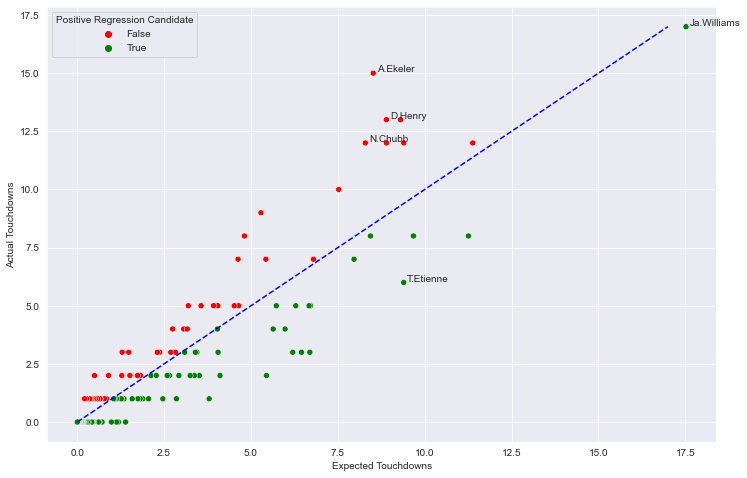

In [19]:
from matplotlib import pyplot as plt;

fig, ax = plt.subplots(figsize=(12, 8))

#New column with either True/False based on if regression candidate is a positive number
exp_df['Positive Regression Candidate'] = exp_df['Regression Candidate'] > 0

#Simple scatter plot
sns.scatterplot(
    x = 'Expected Touchdowns',
    y = 'Actual Touchdowns',
    hue = 'Positive Regression Candidate',
    data = exp_df,
    palette = ['r', 'g'] # red and green
);

max_act_touchdowns = int(exp_df['Actual Touchdowns'].max()) # max TDs
max_exp_touchdowns = int(exp_df['Expected Touchdowns'].max()) # max expected TDs

max_tds = max(max_act_touchdowns, max_exp_touchdowns) # max of actual and expected TDs

#List of notable players we'd like to annotate the visualization with.
notable_players = ['T.Etienne', 'Ja.Williams', 'A.Ekeler', 'D.Henry', 'N.Chubb']

for _, row in exp_df.iterrows():
    if row['Player'] in notable_players: 
        ax.text(
            x = row['Expected Touchdowns']+.1, #add spacing from the point in the x-direction
            y = row['Actual Touchdowns'] + 0.05, #same but in the y-direction
            s = row['Player'] #annotate with the player's name
        )
        
#Add straight line slope 1
x_line = np.linspace(0, max_tds, 100)
y_line = x_line
plt.plot(x_line, y_line, color='blue', linestyle='--')

## Conclusions
- The top 4 negative regression candidates are Austin Ekeler, Derrick Henry, Tony Pollard, and Nick Chubb. Although the analysis indicates they should've scored less TDs than expected, all 4 of them are at the top of the position in the league so it's hard to assume they regress.
- Moving just below those 4, Miles Sanders and Cordarrelle Patterson are next on the list. I might expect them to regress in the TD category because Sanders is on a new team and no longer on the best rushing offense in the league, and the Atlanta Falcons just drafted Bijan Robinson in the 1st round so Patterson is likely not going to be used as an RB anymore.
- These are the 2 players I like most to see some positive TD regression:
1. Brian Robinson: began the year slow after being shot before the season started, should be looking to take a 2nd year leap, averaged 19.7 carries/game his last 7 games so he is sure to get the volume needed to score a few more TDs
2. Joe Mixon: the Bengals no longer have Samaje Perine who scored 4 total TDs last year and he has very little backfield competition, Bengals offense overall is one of the best in the league 